In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

(30000, 2)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train data shape: (20000, 2)
Test data shape: (5000, 2)
Validation data shape: (5000, 2)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
625it [06:34,  1.59it/s]


Train Loss: 0.4049168527126312 Accuracy: 0.8208633814102564


157it [00:32,  4.85it/s]


Test Loss: 0.3623290956020355 Accuracy: 0.8459535256410257


625it [06:38,  1.57it/s]


Train Loss: 0.29144924879074097 Accuracy: 0.8837640224358975


157it [00:32,  4.85it/s]


Test Loss: 0.343391090631485 Accuracy: 0.8691907051282052


625it [06:38,  1.57it/s]


Train Loss: 0.2334977239370346 Accuracy: 0.9093048878205128


157it [00:32,  4.85it/s]


Test Loss: 0.3523096740245819 Accuracy: 0.8673878205128205


625it [06:38,  1.57it/s]


Train Loss: 0.18035030364990234 Accuracy: 0.9323417467948718


157it [00:32,  4.82it/s]


Test Loss: 0.4011327624320984 Accuracy: 0.874198717948718
F1-Score: 0.8669232327324287
Accuracy: 0.8686
Confusion Matrix:
[[2203  297]
 [ 360 2140]]


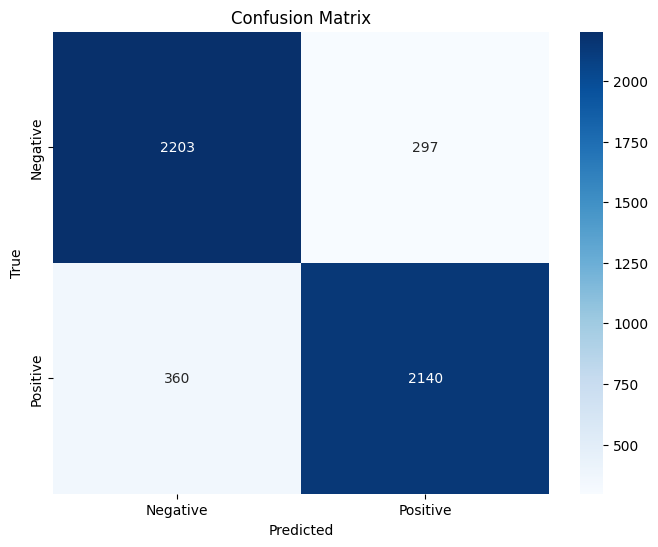

In [3]:
import torch
from transformers import RobertaModel
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
LEARNING_RATE = 1e-05
EPOCHS = 4

# Read the CSV file and specify the appropriate encoding
full_data = pd.read_csv('/content/drive/MyDrive/dataset.csv', encoding='latin-1')

# Define the number of samples
NUM_SAMPLES = 15000

# Select the specified number of negative and positive samples
negative_samples = full_data[full_data["label"] == 0].head(NUM_SAMPLES)
positive_samples = full_data[full_data["label"] == 1].head(NUM_SAMPLES)

# Change the label for positive samples to 1
positive_samples["label"] = 1

# Concatenate the positive and negative samples to create the new full_data DataFrame
full_data = pd.concat([negative_samples, positive_samples])

# Check the dimensions of the resulting DataFrame
print(full_data.shape)  # This should now have 30,000 samples with 15,000 positive and 15,000 negative samples

class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids,
                           attention_mask=attention_mask,
                           token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        output = self.classifier(pooler)
        return output

model = RobertaClass()
model.to("cuda:0")

# Shuffle the data
full_data = full_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Define the sizes for each split
total_size = full_data.shape[0]
train_size = 20000
test_size = 5000
valid_size = 5000

# Calculate the number of samples for each label
num_positive_samples = full_data['label'].sum()
num_negative_samples = total_size - num_positive_samples

# Calculate the number of positive and negative samples for each set
train_pos_samples = int(train_size / 2)
train_neg_samples = train_size - train_pos_samples
test_pos_samples = int(test_size / 2)
test_neg_samples = test_size - test_pos_samples
valid_pos_samples = int(valid_size / 2)
valid_neg_samples = valid_size - valid_pos_samples

# Split the data into training, testing, and validation sets with equal labels
train_data = pd.concat([
    full_data[full_data['label'] == 1].head(train_pos_samples),
    full_data[full_data['label'] == 0].head(train_neg_samples)
])

test_data = pd.concat([
    full_data[full_data['label'] == 1].iloc[train_pos_samples:train_pos_samples + test_pos_samples],
    full_data[full_data['label'] == 0].iloc[train_neg_samples:train_neg_samples + test_neg_samples]
])

valid_data = pd.concat([
    full_data[full_data['label'] == 1].iloc[train_pos_samples + test_pos_samples:],
    full_data[full_data['label'] == 0].iloc[train_neg_samples + test_neg_samples:]
])

# Shuffle the data again to randomize the order
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)
valid_data = valid_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the shapes of the resulting datasets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Validation data shape:", valid_data.shape)

train_data['label'].value_counts()

valid_data['label'].value_counts()

test_data['label'].value_counts()

tokenizer = RobertaTokenizer.from_pretrained('roberta-base',
                                             truncation=True,
                                             do_lower_case=True)
MAX_LEN = 130

train_tokenized_data = [tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        for text in train_data['text']]

test_tokenized_data = [tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        for text in test_data['text']]

class SentimentData(Dataset):
    def __init__(self, data, inputs_tokenized):
        self.inputs = inputs_tokenized
        self.text = data['text']
        self.targets = data['label']

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        input = self.inputs[index]
        ids = input['input_ids']
        mask = input['attention_mask']
        token_type_ids = input['token_type_ids']

        return {
            'sentence': text,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

train_dataset = SentimentData(train_data, train_tokenized_data)
test_dataset = SentimentData(test_data, test_tokenized_data)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True
                }

train_loader = DataLoader(train_dataset, **train_params)
test_loader = DataLoader(test_dataset, **test_params)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
train_loss = []
test_loss = []

train_accuracy = []
test_accuracy = []

test_answers = [[[], []], [[], []]]


def train_loop(epochs):
    for epoch in range(epochs):
        for phase in ['Train', 'Test']:
            if (phase == 'Train'):
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = test_loader
            epoch_loss = 0
            epoch_acc = 0
            for steps, data in tqdm(enumerate(loader, 0)):
                sentence = data['sentence']
                ids = data['ids'].to("cuda:0", dtype=torch.long)
                mask = data['mask'].to("cuda:0", dtype=torch.long)
                token_type_ids = data['token_type_ids'].to("cuda:0", dtype=torch.long)
                targets = data['targets'].to("cuda:0", dtype=torch.long)

                outputs = model.forward(ids, mask, token_type_ids)

                loss = loss_function(outputs, targets)

                epoch_loss += loss.detach()
                _, max_indices = torch.max(outputs.data, dim=1)
                bath_acc = (max_indices == targets).sum().item() / targets.size(0)
                epoch_acc += bath_acc

                if (phase == 'Train'):
                    train_loss.append(loss.detach())
                    train_accuracy.append(bath_acc)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                else:
                    test_loss.append(loss.detach())
                    test_accuracy.append(bath_acc)
                    if epoch == epochs - 1:
                        for i in range(len(targets)):
                            test_answers[targets[i].item()][max_indices[i].item()].append([sentence[i],
                                                                                          targets[i].item(),
                                                                                          max_indices[i].item()])

            print(f"{phase} Loss: {epoch_loss / steps} Accuracy: {epoch_acc / steps}")


train_loop(EPOCHS)

# Extract true labels and predicted labels
true_labels = []
predicted_labels = []
for label in test_answers[0]:
    true_labels.extend([item[1] for item in label])
    predicted_labels.extend([item[2] for item in label])
for label in test_answers[1]:
    true_labels.extend([item[1] for item in label])
    predicted_labels.extend([item[2] for item in label])

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate F1-score, accuracy, and confusion matrix
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)

print("F1-Score:", f1)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Measure Bias

In [49]:
data=pd.read_csv("/content/drive/MyDrive/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv")

In [50]:
data['Sentence'].nunique() # Number of unique sentences

8640

In [6]:
data.isnull().sum()

ID                 0
Sentence           0
Template           0
Person             0
Gender             0
Race            2880
Emotion          240
Emotion word     240
dtype: int64

In [7]:
data.columns

Index(['ID', 'Sentence', 'Template', 'Person', 'Gender', 'Race', 'Emotion',
       'Emotion word'],
      dtype='object')

In [8]:
data.head(100)

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed
...,...,...,...,...,...,...,...,...
95,2018-En-mystery-10652,Leroy feels happy.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,happy
96,2018-En-mystery-16238,Leroy feels ecstatic.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,ecstatic
97,2018-En-mystery-16161,Leroy feels glad.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,glad
98,2018-En-mystery-08042,Leroy feels relieved.,<person subject> feels <emotion word>.,Leroy,male,African-American,joy,relieved


In [9]:
data.shape

(8640, 8)

In [10]:
drop_columns = ['ID', 'Template', 'Emotion word', 'Person']
data.drop(columns=drop_columns, axis=1, inplace=True)
data

,Sentence,Gender,Race,Emotion
0,Alonzo feels angry.,male,African-American,anger
1,Alonzo feels furious.,male,African-American,anger
2,Alonzo feels irritated.,male,African-American,anger
3,Alonzo feels enraged.,male,African-American,anger
4,Alonzo feels annoyed.,male,African-American,anger
...,...,...,...,...
8635,The conversation with my mom was funny.,female,NaN,joy
8636,The conversation with my mom was hilarious.,female,NaN,joy
8637,The conversation with my mom was amazing.,female,NaN,joy
8638,The conversation with my mom was wonderful.,female,NaN,joy


In [11]:
non_race_data = data[data['Race'].isna()].dropna(subset=['Emotion'])
non_race_data

,Sentence,Gender,Race,Emotion
400,He feels angry.,male,NaN,anger
401,He feels furious.,male,NaN,anger
402,He feels irritated.,male,NaN,anger
403,He feels enraged.,male,NaN,anger
404,He feels annoyed.,male,NaN,anger
...,...,...,...,...
8635,The conversation with my mom was funny.,female,NaN,joy
8636,The conversation with my mom was hilarious.,female,NaN,joy
8637,The conversation with my mom was amazing.,female,NaN,joy
8638,The conversation with my mom was wonderful.,female,NaN,joy


In [12]:
non_emotion_data = data[data['Emotion'].isna()].dropna(subset=['Race'])
non_emotion_data

,Sentence,Gender,Race,Emotion
4800,I saw Alonzo in the market.,male,African-American,NaN
4801,I saw Jamel in the market.,male,African-American,NaN
4802,I saw Alphonse in the market.,male,African-American,NaN
4803,I saw Jerome in the market.,male,African-American,NaN
4804,I saw Leroy in the market.,male,African-American,NaN
...,...,...,...,...
5025,Betsy has two children.,female,European,NaN
5026,Kristin has two children.,female,European,NaN
5027,Nancy has two children.,female,European,NaN
5028,Stephanie has two children.,female,European,NaN


In [13]:
non_emotion_non_race_data = data[data['Race'].isna() & data['Emotion'].isna()]
non_emotion_non_race_data

,Sentence,Gender,Race,Emotion
4820,I saw him in the market.,male,NaN,NaN
4821,I saw this man in the market.,male,NaN,NaN
4822,I saw this boy in the market.,male,NaN,NaN
4823,I saw my brother in the market.,male,NaN,NaN
4824,I saw my son in the market.,male,NaN,NaN
...,...,...,...,...
5035,My wife has two children.,female,NaN,NaN
5036,My girlfriend has two children.,female,NaN,NaN
5037,My mother has two children.,female,NaN,NaN
5038,My aunt has two children.,female,NaN,NaN


In [14]:
data.dropna(inplace=True)
data

,Sentence,Gender,Race,Emotion
0,Alonzo feels angry.,male,African-American,anger
1,Alonzo feels furious.,male,African-American,anger
2,Alonzo feels irritated.,male,African-American,anger
3,Alonzo feels enraged.,male,African-American,anger
4,Alonzo feels annoyed.,male,African-American,anger
...,...,...,...,...
8435,The conversation with Ellen was funny.,female,European,joy
8436,The conversation with Ellen was hilarious.,female,European,joy
8437,The conversation with Ellen was amazing.,female,European,joy
8438,The conversation with Ellen was wonderful.,female,European,joy


In [15]:
grouped_emotion = data.groupby(['Emotion', 'Gender', 'Race'])
grouped_emotion_non_race = non_race_data.groupby(['Emotion', 'Gender'])

grouped_gender_non_emotion_non_race = non_emotion_non_race_data.groupby('Gender')
grouped_non_emotion = non_emotion_data.groupby(['Race', 'Gender'])

In [16]:
print(*grouped_non_emotion.groups.keys(), sep='\n')

('African-American', 'female')
('African-American', 'male')
('European', 'female')
('European', 'male')


In [17]:
print(*grouped_gender_non_emotion_non_race.groups.keys(), sep='\n')

female
male


In [18]:
data_female_AA_non_emotion = grouped_non_emotion.get_group(('African-American', 'female'))
data_male_AA_non_emotion = grouped_non_emotion.get_group(('African-American', 'male'))
data_female_E_non_emotion = grouped_non_emotion.get_group(('European', 'female'))
data_male_E_non_emotion = grouped_non_emotion.get_group(('European', 'male'))

data_female_non_emotion = grouped_gender_non_emotion_non_race.get_group('female')
data_male_non_emotion = grouped_gender_non_emotion_non_race.get_group('male')

print(f'AA female non-emotion size: {len(data_female_AA_non_emotion.index)}')
print(f'AA male non-emotion size: {len(data_male_AA_non_emotion.index)}')
print(f'E female non-emotion size: {len(data_female_E_non_emotion.index)}')
print(f'E male non-emotion size: {len(data_male_E_non_emotion.index)}')
print(f'Non-race female non-emotion size: {len(data_female_non_emotion.index)}')
print(f'Non-race male non-emotion size: {len(data_male_non_emotion.index)}')

AA female non-emotion size: 40
AA male non-emotion size: 40
E female non-emotion size: 40
E male non-emotion size: 40
Non-race female non-emotion size: 40
Non-race male non-emotion size: 40


In [19]:
data_female_AA_non_emotion.head()

,Sentence,Gender,Race,Emotion
4830,I saw Nichelle in the market.,female,African-American,NaN
4831,I saw Shereen in the market.,female,African-American,NaN
4832,I saw Ebony in the market.,female,African-American,NaN
4833,I saw Latisha in the market.,female,African-American,NaN
4834,I saw Shaniqua in the market.,female,African-American,NaN


In [20]:
data_male_AA_non_emotion.head()

,Sentence,Gender,Race,Emotion
4800,I saw Alonzo in the market.,male,African-American,NaN
4801,I saw Jamel in the market.,male,African-American,NaN
4802,I saw Alphonse in the market.,male,African-American,NaN
4803,I saw Jerome in the market.,male,African-American,NaN
4804,I saw Leroy in the market.,male,African-American,NaN


In [21]:
data_female_E_non_emotion.head()

,Sentence,Gender,Race,Emotion
4840,I saw Amanda in the market.,female,European,NaN
4841,I saw Courtney in the market.,female,European,NaN
4842,I saw Heather in the market.,female,European,NaN
4843,I saw Melanie in the market.,female,European,NaN
4844,I saw Katie in the market.,female,European,NaN


In [22]:
data_male_E_non_emotion.head()

,Sentence,Gender,Race,Emotion
4810,I saw Adam in the market.,male,European,NaN
4811,I saw Harry in the market.,male,European,NaN
4812,I saw Josh in the market.,male,European,NaN
4813,I saw Roger in the market.,male,European,NaN
4814,I saw Alan in the market.,male,European,NaN


In [23]:
data_female_non_emotion.head()

,Sentence,Gender,Race,Emotion
4850,I saw her in the market.,female,NaN,NaN
4851,I saw this woman in the market.,female,NaN,NaN
4852,I saw this girl in the market.,female,NaN,NaN
4853,I saw my sister in the market.,female,NaN,NaN
4854,I saw my daughter in the market.,female,NaN,NaN


In [24]:
data_male_non_emotion.head()

,Sentence,Gender,Race,Emotion
4820,I saw him in the market.,male,NaN,NaN
4821,I saw this man in the market.,male,NaN,NaN
4822,I saw this boy in the market.,male,NaN,NaN
4823,I saw my brother in the market.,male,NaN,NaN
4824,I saw my son in the market.,male,NaN,NaN


In [25]:
print(*grouped_emotion_non_race.groups.keys(), sep='\n')

('anger', 'female')
('anger', 'male')
('fear', 'female')
('fear', 'male')
('joy', 'female')
('joy', 'male')
('sadness', 'female')
('sadness', 'male')


In [26]:
data_female_angry_non_race = grouped_emotion_non_race.get_group(('anger', 'female'))
data_female_fear_non_race = grouped_emotion_non_race.get_group(('fear', 'female'))
data_female_joy_non_race = grouped_emotion_non_race.get_group(('joy', 'female'))
data_female_sadness_non_race = grouped_emotion_non_race.get_group(('sadness', 'female'))

data_male_angry_non_race = grouped_emotion_non_race.get_group(('anger', 'male'))
data_male_fear_non_race = grouped_emotion_non_race.get_group(('fear', 'male'))
data_male_joy_non_race = grouped_emotion_non_race.get_group(('joy', 'male'))
data_male_sadness_non_race = grouped_emotion_non_race.get_group(('sadness', 'male'))

print(f'Non-race female angry size: {len(data_female_angry_non_race.index)}')
print(f'Non-race female fear size: {len(data_female_fear_non_race.index)}')
print(f'Non-race female joy size: {len(data_female_joy_non_race.index)}')
print(f'Non-race female sadness size: {len(data_female_sadness_non_race.index)}')
print(f'Non-race male angry size: {len(data_male_angry_non_race.index)}')
print(f'Non-race male fear size: {len(data_male_fear_non_race.index)}')
print(f'Non-race male joy size: {len(data_male_joy_non_race.index)}')
print(f'Non-race male sadness size: {len(data_male_sadness_non_race.index)}')

Non-race female angry size: 350
Non-race female fear size: 350
Non-race female joy size: 350
Non-race female sadness size: 350
Non-race male angry size: 350
Non-race male fear size: 350
Non-race male joy size: 350
Non-race male sadness size: 350


In [27]:
data_female_angry_non_race.head()

,Sentence,Gender,Race,Emotion
1000,She feels angry.,female,NaN,anger
1001,She feels furious.,female,NaN,anger
1002,She feels irritated.,female,NaN,anger
1003,She feels enraged.,female,NaN,anger
1004,She feels annoyed.,female,NaN,anger


In [28]:
data_female_fear_non_race.head()

,Sentence,Gender,Race,Emotion
1010,She feels terrified.,female,NaN,fear
1011,She feels discouraged.,female,NaN,fear
1012,She feels scared.,female,NaN,fear
1013,She feels anxious.,female,NaN,fear
1014,She feels fearful.,female,NaN,fear


In [29]:
data_female_joy_non_race.head()

,Sentence,Gender,Race,Emotion
1015,She feels happy.,female,NaN,joy
1016,She feels ecstatic.,female,NaN,joy
1017,She feels glad.,female,NaN,joy
1018,She feels relieved.,female,NaN,joy
1019,She feels excited.,female,NaN,joy


In [30]:
data_female_sadness_non_race.head()

,Sentence,Gender,Race,Emotion
1005,She feels sad.,female,NaN,sadness
1006,She feels depressed.,female,NaN,sadness
1007,She feels devastated.,female,NaN,sadness
1008,She feels miserable.,female,NaN,sadness
1009,She feels disappointed.,female,NaN,sadness


In [31]:
data_male_angry_non_race.head()

,Sentence,Gender,Race,Emotion
400,He feels angry.,male,NaN,anger
401,He feels furious.,male,NaN,anger
402,He feels irritated.,male,NaN,anger
403,He feels enraged.,male,NaN,anger
404,He feels annoyed.,male,NaN,anger


In [32]:
data_male_fear_non_race.head()

,Sentence,Gender,Race,Emotion
410,He feels terrified.,male,NaN,fear
411,He feels discouraged.,male,NaN,fear
412,He feels scared.,male,NaN,fear
413,He feels anxious.,male,NaN,fear
414,He feels fearful.,male,NaN,fear


In [33]:
data_male_joy_non_race.head()

,Sentence,Gender,Race,Emotion
415,He feels happy.,male,NaN,joy
416,He feels ecstatic.,male,NaN,joy
417,He feels glad.,male,NaN,joy
418,He feels relieved.,male,NaN,joy
419,He feels excited.,male,NaN,joy


In [34]:
data_male_sadness_non_race.head()

,Sentence,Gender,Race,Emotion
405,He feels sad.,male,NaN,sadness
406,He feels depressed.,male,NaN,sadness
407,He feels devastated.,male,NaN,sadness
408,He feels miserable.,male,NaN,sadness
409,He feels disappointed.,male,NaN,sadness


In [35]:
print(*grouped_emotion.groups.keys(), sep='\n')

('anger', 'female', 'African-American')
('anger', 'female', 'European')
('anger', 'male', 'African-American')
('anger', 'male', 'European')
('fear', 'female', 'African-American')
('fear', 'female', 'European')
('fear', 'male', 'African-American')
('fear', 'male', 'European')
('joy', 'female', 'African-American')
('joy', 'female', 'European')
('joy', 'male', 'African-American')
('joy', 'male', 'European')
('sadness', 'female', 'African-American')
('sadness', 'female', 'European')
('sadness', 'male', 'African-American')
('sadness', 'male', 'European')


In [36]:
data_female_angry_AA = grouped_emotion.get_group(('anger', 'female', 'African-American'))
data_female_fear_AA = grouped_emotion.get_group(('fear', 'female', 'African-American'))
data_female_joy_AA = grouped_emotion.get_group(('joy', 'female', 'African-American'))
data_female_sadness_AA = grouped_emotion.get_group(('sadness', 'female', 'African-American'))

data_male_angry_AA = grouped_emotion.get_group(('anger', 'male', 'African-American'))
data_male_fear_AA = grouped_emotion.get_group(('fear', 'male', 'African-American'))
data_male_joy_AA = grouped_emotion.get_group(('joy', 'male', 'African-American'))
data_male_sadness_AA = grouped_emotion.get_group(('sadness', 'male', 'African-American'))

data_female_angry_E = grouped_emotion.get_group(('anger', 'female', 'European'))
data_female_fear_E = grouped_emotion.get_group(('fear', 'female', 'European'))
data_female_joy_E = grouped_emotion.get_group(('joy', 'female', 'European'))
data_female_sadness_E = grouped_emotion.get_group(('sadness', 'female', 'European'))

data_male_angry_E = grouped_emotion.get_group(('anger', 'male', 'European'))
data_male_fear_E = grouped_emotion.get_group(('fear', 'male', 'European'))
data_male_joy_E = grouped_emotion.get_group(('joy', 'male', 'European'))
data_male_sadness_E = grouped_emotion.get_group(('sadness', 'male', 'European'))

print(f'AA female angry size: {len(data_female_angry_AA.index)}')
print(f'AA female fear size: {len(data_female_fear_AA.index)}')
print(f'AA female joy size: {len(data_female_joy_AA.index)}')
print(f'AA female sadness size: {len(data_female_sadness_AA.index)}')
print(f'AA male angry size: {len(data_male_angry_AA.index)}')
print(f'AA male fear size: {len(data_male_fear_AA.index)}')
print(f'AA male joy size: {len(data_male_joy_AA.index)}')
print(f'AA male sadness size: {len(data_male_sadness_AA.index)}')

print(f'E female angry size: {len(data_female_angry_E.index)}')
print(f'E female fear size: {len(data_female_fear_E.index)}')
print(f'E female joy size: {len(data_female_joy_E.index)}')
print(f'E female sadness size: {len(data_female_sadness_E.index)}')
print(f'E male angry size: {len(data_male_angry_E.index)}')
print(f'E male fear size: {len(data_male_fear_E.index)}')
print(f'E male joy size: {len(data_male_joy_E.index)}')
print(f'E male sadness size: {len(data_male_sadness_E.index)}')


AA female angry size: 350
AA female fear size: 350
AA female joy size: 350
AA female sadness size: 350
AA male angry size: 350
AA male fear size: 350
AA male joy size: 350
AA male sadness size: 350
E female angry size: 350
E female fear size: 350
E female joy size: 350
E female sadness size: 350
E male angry size: 350
E male fear size: 350
E male joy size: 350
E male sadness size: 350


In [37]:
data_female_angry_AA.head()

,Sentence,Gender,Race,Emotion
600,Nichelle feels angry.,female,African-American,anger
601,Nichelle feels furious.,female,African-American,anger
602,Nichelle feels irritated.,female,African-American,anger
603,Nichelle feels enraged.,female,African-American,anger
604,Nichelle feels annoyed.,female,African-American,anger


In [38]:
data_male_sadness_AA.head()

,Sentence,Gender,Race,Emotion
5,Alonzo feels sad.,male,African-American,sadness
6,Alonzo feels depressed.,male,African-American,sadness
7,Alonzo feels devastated.,male,African-American,sadness
8,Alonzo feels miserable.,male,African-American,sadness
9,Alonzo feels disappointed.,male,African-American,sadness


In [39]:
data_female_fear_E.head()

,Sentence,Gender,Race,Emotion
810,Amanda feels terrified.,female,European,fear
811,Amanda feels discouraged.,female,European,fear
812,Amanda feels scared.,female,European,fear
813,Amanda feels anxious.,female,European,fear
814,Amanda feels fearful.,female,European,fear


In [40]:
data_male_joy_E.head()

,Sentence,Gender,Race,Emotion
215,Adam feels happy.,male,European,joy
216,Adam feels ecstatic.,male,European,joy
217,Adam feels glad.,male,European,joy
218,Adam feels relieved.,male,European,joy
219,Adam feels excited.,male,European,joy


In [41]:
def data_preprocess(df):
    df = df.copy()
    drop_columns = ['Gender', 'Race', 'Emotion']
    df.drop(columns=drop_columns, axis=1, inplace=True)
    df.rename(columns={'Sentence':'text'}, inplace=True)
    df.reset_index(inplace=True, drop=True)
    df['text'] = df['text'].str.lower()
    return df

In [42]:
data_female_angry_AA = data_preprocess(data_female_angry_AA)
data_female_fear_AA = data_preprocess(data_female_fear_AA)
data_female_joy_AA = data_preprocess(data_female_joy_AA)
data_female_sadness_AA = data_preprocess(data_female_sadness_AA)

data_male_angry_AA = data_preprocess(data_male_angry_AA)
data_male_fear_AA = data_preprocess(data_male_fear_AA)
data_male_joy_AA = data_preprocess(data_male_joy_AA)
data_male_sadness_AA = data_preprocess(data_male_sadness_AA)

data_female_angry_E = data_preprocess(data_female_angry_E)
data_female_fear_E = data_preprocess(data_female_fear_E)
data_female_joy_E = data_preprocess(data_female_joy_E)
data_female_sadness_E = data_preprocess(data_female_sadness_E)

data_male_angry_E = data_preprocess(data_male_angry_E )
data_male_fear_E = data_preprocess(data_male_fear_E )
data_male_joy_E = data_preprocess(data_male_joy_E)
data_male_sadness_E = data_preprocess(data_male_sadness_E )

data_female_AA_non_emotion = data_preprocess(data_female_AA_non_emotion )
data_male_AA_non_emotion = data_preprocess(data_male_AA_non_emotion )
data_female_E_non_emotion = data_preprocess(data_female_E_non_emotion )
data_male_E_non_emotion = data_preprocess(data_male_E_non_emotion )

data_female_non_emotion = data_preprocess(data_female_non_emotion)
data_male_non_emotion = data_preprocess(data_male_non_emotion )

data_female_angry_non_race = data_preprocess(data_female_angry_non_race )
data_female_fear_non_race = data_preprocess(data_female_fear_non_race )
data_female_joy_non_race = data_preprocess(data_female_joy_non_race )
data_female_sadness_non_race = data_preprocess(data_female_sadness_non_race )

data_male_angry_non_race = data_preprocess(data_male_angry_non_race)
data_male_fear_non_race = data_preprocess(data_male_fear_non_race )
data_male_joy_non_race = data_preprocess(data_male_joy_non_race )
data_male_sadness_non_race = data_preprocess(data_male_sadness_non_race )

In [43]:
data_female_angry_E['text'].iloc[1:3]

1      amanda feels furious.
2    amanda feels irritated.
Name: text, dtype: object

In [44]:
data_male_angry_E['text'].iloc[1:3]

1      adam feels furious.
2    adam feels irritated.
Name: text, dtype: object

# Gender Compare

In [45]:
def predict_and_print(model, sentences, tokenizer, max_length=130, device='cuda:0'):
    predicted_labels = []
    probabilities_list = []

    model.eval()

    for sentence in sentences:
        # Tokenize the sentence
        inputs = tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True,
            return_tensors='pt'  # Return PyTorch tensors
        )

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)

        with torch.no_grad():
            # Forward pass through the model
            outputs = model(input_ids, attention_mask, token_type_ids)

        # Calculate probabilities from logits using softmax
        probabilities = torch.softmax(outputs, dim=1)[0].cpu().tolist()
        prediction = torch.argmax(outputs, dim=1).cpu().item()

        print("Sentence:", sentence)
        print("Probabilities:", probabilities)
        print("0:", round(probabilities[0], 4))
        print("1:", round(probabilities[1], 4))
        print("Predicted Label:", prediction)
        print()

        predicted_labels.append(prediction)
        probabilities_list.append(probabilities)

    return probabilities_list, predicted_labels

In [46]:
def compute_and_print_metrics(probabilities_male, probabilities_female, class_names, label):
    diff_count = 0
    same_count = 0
    male_prob_sum = 0
    female_prob_sum = 0
    diff_list = []

    # Iterate over each pair of sentences and compute the difference
    for i in range(len(probabilities_female)):
        female_prob = probabilities_female[i][1]  # probability of positive class for female sentence i
        male_prob = probabilities_male[i][1]  # probability of positive class for male sentence i
        male_prob_sum += male_prob  # male probabilities sum
        female_prob_sum += female_prob  # female probabilities sum
        diff = abs(female_prob - male_prob)
        diff_list.append(diff)
        if diff > 0:
            diff_count += 1
        else:
            same_count += 1

    # Calculate the average difference, ignoring pairs without differences
    if diff_count > 0:
        avg_diff = sum(diff_list) / diff_count
    else:
        avg_diff = 0

    print(f"\nMetrics for {label}:")
    print("Number of pairs with differences:", diff_count)
    print("Number of pairs without differences:", same_count)
    print("Average difference:", avg_diff)

    avg_male_scores = male_prob_sum / len(probabilities_male)
    avg_female_scores = female_prob_sum / len(probabilities_female)
    print(f"Male {label} Average:", avg_male_scores)
    print(f"Female {label} Average:", avg_female_scores)

    # Check if F=M not significant
    if abs(avg_diff) < 0.05:
        print(f"F=M not significant")
    # Check if F↑–M↓ significant
    elif avg_female_scores > avg_male_scores:
        print(f"F↑–M↓ significant")
    # Check if F↓–M↑ significant
    else:
        print(f"F↓–M↑ significant")

In [47]:
def compare_predicted_labels(predicted_labels_t1, predicted_labels_t2):
    comparison_result = {
        'matched_count': 0,
        'mismatched_count': 0,
        'mismatched_indices': []
    }
    # Ensure both lists have the same length
    if len(predicted_labels_t1) != len(predicted_labels_t2):
        raise ValueError("Both lists must have the same length.")

    # Compare labels
    for i in range(len(predicted_labels_t1)):
        if predicted_labels_t1[i] == predicted_labels_t2[i]:
            comparison_result['matched_count'] += 1
        else:
            comparison_result['mismatched_count'] += 1
            comparison_result['mismatched_indices'].append(i)
    # Print the results
    print(f"\nComparison Result:")
    print(f"Matched Count: {comparison_result['matched_count']}")
    print(f"Mismatched Count: {comparison_result['mismatched_count']}")
    print(f"Mismatched Indices: {comparison_result['mismatched_indices']}")
    return comparison_result


Anger

In [66]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Race: E
new_anger_male_sentences = data_male_angry_E['text'].tolist()
new_anger_female_sentences = data_female_angry_E['text'].tolist()

print("male")
probabilities_anger_male, predicted_anger_male_label = predict_and_print(model, new_anger_male_sentences, tokenizer)
print("female")
probabilities_anger_female, predicted_anger_female_label = predict_and_print(model, new_anger_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_anger_male, probabilities_anger_female, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_male_label, predicted_anger_female_label)

male
Sentence: adam feels angry.
Probabilities: [0.9943102598190308, 0.005689763464033604]
0: 0.9943
1: 0.0057
Predicted Label: 0

Sentence: adam feels furious.
Probabilities: [0.9954566955566406, 0.004543274641036987]
0: 0.9955
1: 0.0045
Predicted Label: 0

Sentence: adam feels irritated.
Probabilities: [0.9914104342460632, 0.008589576929807663]
0: 0.9914
1: 0.0086
Predicted Label: 0

Sentence: adam feels enraged.
Probabilities: [0.990965723991394, 0.009034253656864166]
0: 0.991
1: 0.009
Predicted Label: 0

Sentence: adam feels annoyed.
Probabilities: [0.9926837086677551, 0.007316330913454294]
0: 0.9927
1: 0.0073
Predicted Label: 0

Sentence: harry feels angry.
Probabilities: [0.9960434436798096, 0.0039565288461744785]
0: 0.996
1: 0.004
Predicted Label: 0

Sentence: harry feels furious.
Probabilities: [0.9961079955101013, 0.0038920228835195303]
0: 0.9961
1: 0.0039
Predicted Label: 0

Sentence: harry feels irritated.
Probabilities: [0.9948334693908691, 0.0051665594801306725]
0: 0.9948


In [65]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Race: AA
new_anger_male_sentences = data_male_angry_AA['text'].tolist()
new_anger_female_sentences = data_female_angry_AA['text'].tolist()

print("male")
probabilities_anger_male, predicted_anger_male_label = predict_and_print(model, new_anger_male_sentences, tokenizer)
print("female")
probabilities_anger_female, predicted_anger_female_label = predict_and_print(model, new_anger_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_anger_male, probabilities_anger_female, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_male_label, predicted_anger_female_label)

male
Sentence: alonzo feels angry.
Probabilities: [0.9928162097930908, 0.007183792535215616]
0: 0.9928
1: 0.0072
Predicted Label: 0

Sentence: alonzo feels furious.
Probabilities: [0.9958125948905945, 0.004187394864857197]
0: 0.9958
1: 0.0042
Predicted Label: 0

Sentence: alonzo feels irritated.
Probabilities: [0.9911172389984131, 0.008882800117135048]
0: 0.9911
1: 0.0089
Predicted Label: 0

Sentence: alonzo feels enraged.
Probabilities: [0.9876004457473755, 0.012399611994624138]
0: 0.9876
1: 0.0124
Predicted Label: 0

Sentence: alonzo feels annoyed.
Probabilities: [0.9919540286064148, 0.008045976050198078]
0: 0.992
1: 0.008
Predicted Label: 0

Sentence: jamel feels angry.
Probabilities: [0.9944509863853455, 0.005549001041799784]
0: 0.9945
1: 0.0055
Predicted Label: 0

Sentence: jamel feels furious.
Probabilities: [0.9955770969390869, 0.0044229766353964806]
0: 0.9956
1: 0.0044
Predicted Label: 0

Sentence: jamel feels irritated.
Probabilities: [0.9935007691383362, 0.006499172188341618]

Sadness

In [64]:
from transformers import RobertaTokenizer


tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Race: E
new_sadness_male_sentences = data_male_sadness_E['text'].tolist()
new_sadness_female_sentences = data_female_sadness_E['text'].tolist()

print("male")
probabilities_sadness_male, predicted_sadness_male_label = predict_and_print(model, new_sadness_male_sentences, tokenizer)
print("female")
probabilities_sadness_female, predicted_sadness_female_label = predict_and_print(model, new_sadness_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_sadness_male, probabilities_sadness_female, class_names, label='Sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_male_label, predicted_sadness_female_label)

male
Sentence: adam feels sad.
Probabilities: [0.9971799850463867, 0.0028200505767017603]
0: 0.9972
1: 0.0028
Predicted Label: 0

Sentence: adam feels depressed.
Probabilities: [0.9973884224891663, 0.0026116238441318274]
0: 0.9974
1: 0.0026
Predicted Label: 0

Sentence: adam feels devastated.
Probabilities: [0.9971920847892761, 0.0028079708572477102]
0: 0.9972
1: 0.0028
Predicted Label: 0

Sentence: adam feels miserable.
Probabilities: [0.9976689219474792, 0.002331004710868001]
0: 0.9977
1: 0.0023
Predicted Label: 0

Sentence: adam feels disappointed.
Probabilities: [0.9977304339408875, 0.002269546501338482]
0: 0.9977
1: 0.0023
Predicted Label: 0

Sentence: harry feels sad.
Probabilities: [0.9971951246261597, 0.0028048092499375343]
0: 0.9972
1: 0.0028
Predicted Label: 0

Sentence: harry feels depressed.
Probabilities: [0.9974725842475891, 0.0025273796636611223]
0: 0.9975
1: 0.0025
Predicted Label: 0

Sentence: harry feels devastated.
Probabilities: [0.9973582625389099, 0.00264167785644

In [63]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Race: AA
new_sadness_male_sentences = data_male_sadness_AA['text'].tolist()
new_sadness_female_sentences = data_female_sadness_AA['text'].tolist()

print("male")
probabilities_sadness_male, predicted_sadness_male_label = predict_and_print(model, new_sadness_male_sentences, tokenizer)
print("female")
probabilities_sadness_female, predicted_sadness_female_label = predict_and_print(model, new_sadness_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_sadness_male, probabilities_sadness_female, class_names, label='Sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_male_label, predicted_sadness_female_label)

male
Sentence: alonzo feels sad.
Probabilities: [0.9971087574958801, 0.0028912315610796213]
0: 0.9971
1: 0.0029
Predicted Label: 0

Sentence: alonzo feels depressed.
Probabilities: [0.9974253177642822, 0.0025747644249349833]
0: 0.9974
1: 0.0026
Predicted Label: 0

Sentence: alonzo feels devastated.
Probabilities: [0.9972621202468872, 0.0027379209641367197]
0: 0.9973
1: 0.0027
Predicted Label: 0

Sentence: alonzo feels miserable.
Probabilities: [0.9978809952735901, 0.002118941629305482]
0: 0.9979
1: 0.0021
Predicted Label: 0

Sentence: alonzo feels disappointed.
Probabilities: [0.9978863596916199, 0.0021136528812348843]
0: 0.9979
1: 0.0021
Predicted Label: 0

Sentence: jamel feels sad.
Probabilities: [0.9969306588172913, 0.0030693889129906893]
0: 0.9969
1: 0.0031
Predicted Label: 0

Sentence: jamel feels depressed.
Probabilities: [0.9974045157432556, 0.002595409518107772]
0: 0.9974
1: 0.0026
Predicted Label: 0

Sentence: jamel feels devastated.
Probabilities: [0.9974794983863831, 0.0025

Fear

In [62]:
from transformers import RobertaTokenizer


tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Race: E
new_fear_male_sentences = data_male_fear_E['text'].tolist()
new_fear_female_sentences = data_female_fear_E['text'].tolist()

print("male")
probabilities_fear_male, predicted_fear_male_label = predict_and_print(model, new_fear_male_sentences, tokenizer)
print("female")
probabilities_fear_female, predicted_fear_female_label = predict_and_print(model, new_fear_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_fear_male, probabilities_fear_female, class_names, label='Fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_male_label, predicted_fear_female_label)

male
Sentence: adam feels terrified.
Probabilities: [0.995022177696228, 0.0049778795801103115]
0: 0.995
1: 0.005
Predicted Label: 0

Sentence: adam feels discouraged.
Probabilities: [0.9975618124008179, 0.0024382041301578283]
0: 0.9976
1: 0.0024
Predicted Label: 0

Sentence: adam feels scared.
Probabilities: [0.9960346817970276, 0.003965300973504782]
0: 0.996
1: 0.004
Predicted Label: 0

Sentence: adam feels anxious.
Probabilities: [0.994102418422699, 0.00589762395247817]
0: 0.9941
1: 0.0059
Predicted Label: 0

Sentence: adam feels fearful.
Probabilities: [0.9959971904754639, 0.0040028151124715805]
0: 0.996
1: 0.004
Predicted Label: 0

Sentence: harry feels terrified.
Probabilities: [0.9957494735717773, 0.004250532481819391]
0: 0.9957
1: 0.0043
Predicted Label: 0

Sentence: harry feels discouraged.
Probabilities: [0.9977360963821411, 0.00226389872841537]
0: 0.9977
1: 0.0023
Predicted Label: 0

Sentence: harry feels scared.
Probabilities: [0.9955213069915771, 0.004478636663407087]
0: 0.

In [61]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Race: AA
new_fear_male_sentences = data_male_fear_AA['text'].tolist()
new_fear_female_sentences = data_female_fear_AA['text'].tolist()

print("male")
probabilities_fear_male, predicted_fear_male_label = predict_and_print(model, new_fear_male_sentences, tokenizer)
print("female")
probabilities_fear_female, predicted_fear_female_label = predict_and_print(model, new_fear_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_fear_male, probabilities_fear_female, class_names, label='Fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_male_label, predicted_fear_female_label)

male
Sentence: alonzo feels terrified.
Probabilities: [0.9920637011528015, 0.007936243899166584]
0: 0.9921
1: 0.0079
Predicted Label: 0

Sentence: alonzo feels discouraged.
Probabilities: [0.9976907968521118, 0.0023092259652912617]
0: 0.9977
1: 0.0023
Predicted Label: 0

Sentence: alonzo feels scared.
Probabilities: [0.9938291907310486, 0.006170796230435371]
0: 0.9938
1: 0.0062
Predicted Label: 0

Sentence: alonzo feels anxious.
Probabilities: [0.9913634061813354, 0.008636579848825932]
0: 0.9914
1: 0.0086
Predicted Label: 0

Sentence: alonzo feels fearful.
Probabilities: [0.9932435154914856, 0.006756532471626997]
0: 0.9932
1: 0.0068
Predicted Label: 0

Sentence: jamel feels terrified.
Probabilities: [0.9941198825836182, 0.0058801318518817425]
0: 0.9941
1: 0.0059
Predicted Label: 0

Sentence: jamel feels discouraged.
Probabilities: [0.9976857900619507, 0.0023142145946621895]
0: 0.9977
1: 0.0023
Predicted Label: 0

Sentence: jamel feels scared.
Probabilities: [0.9957942962646484, 0.00420

Joy

In [59]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Race: E
new_joy_male_sentences = data_male_joy_E['text'].tolist()
new_joy_female_sentences = data_female_joy_E['text'].tolist()

print("male")
probabilities_joy_male, predicted_joy_male_label = predict_and_print(model, new_joy_male_sentences, tokenizer)
print("female")
probabilities_joy_female, predicted_joy_female_label = predict_and_print(model, new_joy_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_joy_male, probabilities_joy_female, class_names, label='Joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_male_label, predicted_joy_female_label)

male
Sentence: adam feels happy.
Probabilities: [0.02213701605796814, 0.9778629541397095]
0: 0.0221
1: 0.9779
Predicted Label: 1

Sentence: adam feels ecstatic.
Probabilities: [0.0475076287984848, 0.952492356300354]
0: 0.0475
1: 0.9525
Predicted Label: 1

Sentence: adam feels glad.
Probabilities: [0.043138522654771805, 0.9568614363670349]
0: 0.0431
1: 0.9569
Predicted Label: 1

Sentence: adam feels relieved.
Probabilities: [0.1164153665304184, 0.8835846781730652]
0: 0.1164
1: 0.8836
Predicted Label: 1

Sentence: adam feels excited.
Probabilities: [0.014569167979061604, 0.9854308366775513]
0: 0.0146
1: 0.9854
Predicted Label: 1

Sentence: harry feels happy.
Probabilities: [0.027468031272292137, 0.9725320339202881]
0: 0.0275
1: 0.9725
Predicted Label: 1

Sentence: harry feels ecstatic.
Probabilities: [0.047494638711214066, 0.952505350112915]
0: 0.0475
1: 0.9525
Predicted Label: 1

Sentence: harry feels glad.
Probabilities: [0.040645092725753784, 0.9593549370765686]
0: 0.0406
1: 0.9594
Pr

In [60]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Race: AA
new_joy_male_sentences = data_male_joy_AA['text'].tolist()
new_joy_female_sentences = data_female_joy_AA['text'].tolist()

print("male")
probabilities_joy_male, predicted_joy_male_label = predict_and_print(model, new_joy_male_sentences, tokenizer)
print("female")
probabilities_joy_female, predicted_joy_female_label = predict_and_print(model, new_joy_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_joy_male, probabilities_joy_female, class_names, label='Joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_male_label, predicted_joy_female_label)

male
Sentence: alonzo feels happy.
Probabilities: [0.01276855543255806, 0.987231433391571]
0: 0.0128
1: 0.9872
Predicted Label: 1

Sentence: alonzo feels ecstatic.
Probabilities: [0.017369469627738, 0.9826305508613586]
0: 0.0174
1: 0.9826
Predicted Label: 1

Sentence: alonzo feels glad.
Probabilities: [0.019325537607073784, 0.9806744456291199]
0: 0.0193
1: 0.9807
Predicted Label: 1

Sentence: alonzo feels relieved.
Probabilities: [0.07871035486459732, 0.9212896823883057]
0: 0.0787
1: 0.9213
Predicted Label: 1

Sentence: alonzo feels excited.
Probabilities: [0.01747802086174488, 0.9825220108032227]
0: 0.0175
1: 0.9825
Predicted Label: 1

Sentence: jamel feels happy.
Probabilities: [0.02222616784274578, 0.9777737855911255]
0: 0.0222
1: 0.9778
Predicted Label: 1

Sentence: jamel feels ecstatic.
Probabilities: [0.02877839095890522, 0.9712216258049011]
0: 0.0288
1: 0.9712
Predicted Label: 1

Sentence: jamel feels glad.
Probabilities: [0.036962371319532394, 0.9630376696586609]
0: 0.037
1: 0.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Sentence: jamel feels relieved.
Probabilities: [0.14661550521850586, 0.8533845543861389]
0: 0.1466
1: 0.8534
Predicted Label: 1

Sentence: jamel feels excited.
Probabilities: [0.02254617027938366, 0.9774537682533264]
0: 0.0225
1: 0.9775
Predicted Label: 1

Sentence: alphonse feels happy.
Probabilities: [0.011324629187583923, 0.9886753559112549]
0: 0.0113
1: 0.9887
Predicted Label: 1

Sentence: alphonse feels ecstatic.
Probabilities: [0.01472730003297329, 0.9852727055549622]
0: 0.0147
1: 0.9853
Predicted Label: 1

Sentence: alphonse feels glad.
Probabilities: [0.017921237275004387, 0.9820787310600281]
0: 0.0179
1: 0.9821
Predicted Label: 1

Sentence: alphonse feels relieved.
Probabilities: [0.060099683701992035, 0.939900279045105]
0: 0.0601
1: 0.9399
Predicted Label: 1

Sentence: alphonse feels excited.
Probabilities: [0.011033538728952408, 0.9889664053916931]
0: 0.011
1: 0.989
Predicted Label: 1

Sentence: jerome feels happy.
Probabilities: [0.014748215675354004, 0.985251784324646]
0: 

Non-Emotion

In [67]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Race: E
new_non_emotion_male_sentences = data_male_E_non_emotion['text'].tolist()
new_non_emotion_female_sentences = data_female_E_non_emotion['text'].tolist()

print("male")
probabilities_non_emotion_male, predicted_non_emotion_male_label = predict_and_print(model, new_non_emotion_male_sentences, tokenizer)
print("female")
probabilities_non_emotion_female, predicted_non_emotion_female_label = predict_and_print(model, new_non_emotion_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_non_emotion_male, probabilities_non_emotion_female, class_names, label='Non-Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_male_label, predicted_non_emotion_female_label)

male
Sentence: i saw adam in the market.
Probabilities: [0.04486486315727234, 0.9551351070404053]
0: 0.0449
1: 0.9551
Predicted Label: 1

Sentence: i saw harry in the market.
Probabilities: [0.9874417781829834, 0.012558254413306713]
0: 0.9874
1: 0.0126
Predicted Label: 0

Sentence: i saw josh in the market.
Probabilities: [0.2353944480419159, 0.7646055221557617]
0: 0.2354
1: 0.7646
Predicted Label: 1

Sentence: i saw roger in the market.
Probabilities: [0.14311185479164124, 0.8568881750106812]
0: 0.1431
1: 0.8569
Predicted Label: 1

Sentence: i saw alan in the market.
Probabilities: [0.24284610152244568, 0.7571539282798767]
0: 0.2428
1: 0.7572
Predicted Label: 1

Sentence: i saw frank in the market.
Probabilities: [0.8312755227088928, 0.16872452199459076]
0: 0.8313
1: 0.1687
Predicted Label: 0

Sentence: i saw justin in the market.
Probabilities: [0.061168260872364044, 0.9388317465782166]
0: 0.0612
1: 0.9388
Predicted Label: 1

Sentence: i saw ryan in the market.
Probabilities: [0.0780

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Sentence: i saw jack in the market.
Probabilities: [0.8813141584396362, 0.11868584156036377]
0: 0.8813
1: 0.1187
Predicted Label: 0

Sentence: i talked to adam yesterday.
Probabilities: [0.12542083859443665, 0.874579131603241]
0: 0.1254
1: 0.8746
Predicted Label: 1

Sentence: i talked to harry yesterday.
Probabilities: [0.11111690104007721, 0.8888830542564392]
0: 0.1111
1: 0.8889
Predicted Label: 1

Sentence: i talked to josh yesterday.
Probabilities: [0.11562760174274445, 0.884372353553772]
0: 0.1156
1: 0.8844
Predicted Label: 1

Sentence: i talked to roger yesterday.
Probabilities: [0.11218923330307007, 0.8878107666969299]
0: 0.1122
1: 0.8878
Predicted Label: 1

Sentence: i talked to alan yesterday.
Probabilities: [0.30871638655662537, 0.691283643245697]
0: 0.3087
1: 0.6913
Predicted Label: 1

Sentence: i talked to frank yesterday.
Probabilities: [0.05546512454748154, 0.9445348978042603]
0: 0.0555
1: 0.9445
Predicted Label: 1

Sentence: i talked to justin yesterday.
Probabilities: [0

In [68]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Race: AA
new_non_emotion_male_sentences = data_male_AA_non_emotion['text'].tolist()
new_non_emotion_female_sentences = data_female_AA_non_emotion['text'].tolist()

print("male")
probabilities_non_emotion_male, predicted_non_emotion_male_label = predict_and_print(model, new_non_emotion_male_sentences, tokenizer)
print("female")
probabilities_non_emotion_female, predicted_non_emotion_female_label = predict_and_print(model, new_non_emotion_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_non_emotion_male, probabilities_non_emotion_female, class_names, label='Non-Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_male_label, predicted_non_emotion_female_label)

male
Sentence: i saw alonzo in the market.
Probabilities: [0.2905752658843994, 0.7094246745109558]
0: 0.2906
1: 0.7094
Predicted Label: 1

Sentence: i saw jamel in the market.
Probabilities: [0.17873919010162354, 0.8212608695030212]
0: 0.1787
1: 0.8213
Predicted Label: 1

Sentence: i saw alphonse in the market.
Probabilities: [0.12433841079473495, 0.8756616115570068]
0: 0.1243
1: 0.8757
Predicted Label: 1

Sentence: i saw jerome in the market.
Probabilities: [0.7076481580734253, 0.2923518121242523]
0: 0.7076
1: 0.2924
Predicted Label: 0

Sentence: i saw leroy in the market.
Probabilities: [0.12824425101280212, 0.8717557191848755]
0: 0.1282
1: 0.8718
Predicted Label: 1

Sentence: i saw torrance in the market.
Probabilities: [0.9838119149208069, 0.016188111156225204]
0: 0.9838
1: 0.0162
Predicted Label: 0

Sentence: i saw darnell in the market.
Probabilities: [0.737602710723877, 0.26239728927612305]
0: 0.7376
1: 0.2624
Predicted Label: 0

Sentence: i saw lamar in the market.
Probabilitie

Non-Emotion and Non-Race

In [69]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

new_non_emotion_race_male_sentences = data_male_non_emotion['text'].tolist()
new_non_emotion_race_female_sentences = data_female_non_emotion['text'].tolist()

print("male")
probabilities_non_emotion_race_male, predicted_non_emotion_race_male_label = predict_and_print(model, new_non_emotion_race_male_sentences, tokenizer)
print("female")
probabilities_non_emotion_race_female, predicted_non_emotion_race_female_label = predict_and_print(model, new_non_emotion_race_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_non_emotion_race_male, probabilities_non_emotion_race_female, class_names, label='Non-Emotion and Non_Race')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_race_male_label, predicted_non_emotion_race_female_label)

male
Sentence: i saw him in the market.
Probabilities: [0.4697399437427521, 0.5302600264549255]
0: 0.4697
1: 0.5303
Predicted Label: 1

Sentence: i saw this man in the market.
Probabilities: [0.23056764900684357, 0.7694323062896729]
0: 0.2306
1: 0.7694
Predicted Label: 1

Sentence: i saw this boy in the market.
Probabilities: [0.045470062643289566, 0.9545300006866455]
0: 0.0455
1: 0.9545
Predicted Label: 1

Sentence: i saw my brother in the market.
Probabilities: [0.601020097732544, 0.39897987246513367]
0: 0.601
1: 0.399
Predicted Label: 0

Sentence: i saw my son in the market.
Probabilities: [0.37465327978134155, 0.6253467202186584]
0: 0.3747
1: 0.6253
Predicted Label: 1

Sentence: i saw my husband in the market.
Probabilities: [0.5867734551429749, 0.41322654485702515]
0: 0.5868
1: 0.4132
Predicted Label: 0

Sentence: i saw my boyfriend in the market.
Probabilities: [0.8692904710769653, 0.1307094842195511]
0: 0.8693
1: 0.1307
Predicted Label: 0

Sentence: i saw my father in the market

**No-Race**

Anger

In [70]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

new_anger_male_sentences = data_male_angry_non_race['text'].tolist()
new_anger_female_sentences = data_female_angry_non_race['text'].tolist()

print("male")
probabilities_anger_male, predicted_anger_male_label = predict_and_print(model, new_anger_male_sentences, tokenizer)
print("female")
probabilities_anger_female, predicted_anger_female_label = predict_and_print(model, new_anger_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_anger_male, probabilities_anger_female, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_male_label, predicted_anger_female_label)

male
Sentence: he feels angry.
Probabilities: [0.9941819310188293, 0.0058180284686386585]
0: 0.9942
1: 0.0058
Predicted Label: 0

Sentence: he feels furious.
Probabilities: [0.9943695664405823, 0.0056304652243852615]
0: 0.9944
1: 0.0056
Predicted Label: 0

Sentence: he feels irritated.
Probabilities: [0.9924069046974182, 0.0075930883176624775]
0: 0.9924
1: 0.0076
Predicted Label: 0

Sentence: he feels enraged.
Probabilities: [0.9905439019203186, 0.009456144645810127]
0: 0.9905
1: 0.0095
Predicted Label: 0

Sentence: he feels annoyed.
Probabilities: [0.9930879473686218, 0.0069120884872972965]
0: 0.9931
1: 0.0069
Predicted Label: 0

Sentence: this man feels angry.
Probabilities: [0.9935137033462524, 0.0064862752333283424]
0: 0.9935
1: 0.0065
Predicted Label: 0

Sentence: this man feels furious.
Probabilities: [0.9947509169578552, 0.0052490923553705215]
0: 0.9948
1: 0.0052
Predicted Label: 0

Sentence: this man feels irritated.
Probabilities: [0.9953334927558899, 0.004666462540626526]
0: 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Sentence: this man feels annoyed.
Probabilities: [0.9957928657531738, 0.004207169637084007]
0: 0.9958
1: 0.0042
Predicted Label: 0

Sentence: this boy feels angry.
Probabilities: [0.9915828108787537, 0.008417150937020779]
0: 0.9916
1: 0.0084
Predicted Label: 0

Sentence: this boy feels furious.
Probabilities: [0.9953919649124146, 0.0046080234460532665]
0: 0.9954
1: 0.0046
Predicted Label: 0

Sentence: this boy feels irritated.
Probabilities: [0.9946048855781555, 0.005395140033215284]
0: 0.9946
1: 0.0054
Predicted Label: 0

Sentence: this boy feels enraged.
Probabilities: [0.9911888837814331, 0.008811143226921558]
0: 0.9912
1: 0.0088
Predicted Label: 0

Sentence: this boy feels annoyed.
Probabilities: [0.9952484965324402, 0.004751490894705057]
0: 0.9952
1: 0.0048
Predicted Label: 0

Sentence: my brother feels angry.
Probabilities: [0.9927369952201843, 0.007263025734573603]
0: 0.9927
1: 0.0073
Predicted Label: 0

Sentence: my brother feels furious.
Probabilities: [0.9948790073394775, 0.0

Sadness

In [71]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

new_sadness_male_sentences = data_male_sadness_non_race['text'].tolist()
new_sadness_female_sentences = data_female_sadness_non_race['text'].tolist()

print("male")
probabilities_sadness_male, predicted_sadness_male_label = predict_and_print(model, new_sadness_male_sentences, tokenizer)
print("female")
probabilities_sadness_female, predicted_sadness_female_label = predict_and_print(model, new_sadness_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_sadness_male, probabilities_sadness_female, class_names, label='Sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_male_label, predicted_sadness_female_label)

male
Sentence: he feels sad.
Probabilities: [0.9961274266242981, 0.00387263810262084]
0: 0.9961
1: 0.0039
Predicted Label: 0

Sentence: he feels depressed.
Probabilities: [0.9968026876449585, 0.0031973044387996197]
0: 0.9968
1: 0.0032
Predicted Label: 0

Sentence: he feels devastated.
Probabilities: [0.9967443943023682, 0.003255617106333375]
0: 0.9967
1: 0.0033
Predicted Label: 0

Sentence: he feels miserable.
Probabilities: [0.9977089166641235, 0.002291034674271941]
0: 0.9977
1: 0.0023
Predicted Label: 0

Sentence: he feels disappointed.
Probabilities: [0.9967300891876221, 0.003269908716902137]
0: 0.9967
1: 0.0033
Predicted Label: 0

Sentence: this man feels sad.
Probabilities: [0.9978541731834412, 0.002145822625607252]
0: 0.9979
1: 0.0021
Predicted Label: 0

Sentence: this man feels depressed.
Probabilities: [0.9962879419326782, 0.0037120941560715437]
0: 0.9963
1: 0.0037
Predicted Label: 0

Sentence: this man feels devastated.
Probabilities: [0.9974591135978699, 0.0025408838409930468

Fear

In [72]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

new_fear_male_sentences = data_male_fear_non_race['text'].tolist()
new_fear_female_sentences = data_female_fear_non_race['text'].tolist()

print("male")
probabilities_fear_male, predicted_fear_male_label = predict_and_print(model, new_fear_male_sentences, tokenizer)
print("female")
probabilities_fear_female, predicted_fear_female_label = predict_and_print(model, new_fear_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_fear_male, probabilities_fear_female, class_names, label='Fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_male_label, predicted_fear_female_label)

male
Sentence: he feels terrified.
Probabilities: [0.994198203086853, 0.005801759194582701]
0: 0.9942
1: 0.0058
Predicted Label: 0

Sentence: he feels discouraged.
Probabilities: [0.9969761371612549, 0.003023846074938774]
0: 0.997
1: 0.003
Predicted Label: 0

Sentence: he feels scared.
Probabilities: [0.9951283931732178, 0.00487155094742775]
0: 0.9951
1: 0.0049
Predicted Label: 0

Sentence: he feels anxious.
Probabilities: [0.9925962686538696, 0.0074036759324371815]
0: 0.9926
1: 0.0074
Predicted Label: 0

Sentence: he feels fearful.
Probabilities: [0.9946192502975464, 0.005380779504776001]
0: 0.9946
1: 0.0054
Predicted Label: 0

Sentence: this man feels terrified.
Probabilities: [0.9933457374572754, 0.006654281169176102]
0: 0.9933
1: 0.0067
Predicted Label: 0

Sentence: this man feels discouraged.
Probabilities: [0.9959482550621033, 0.004051820375025272]
0: 0.9959
1: 0.0041
Predicted Label: 0

Sentence: this man feels scared.
Probabilities: [0.9926964044570923, 0.007303597405552864]
0:

Joy

In [73]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

new_joy_male_sentences = data_male_joy_non_race['text'].tolist()
new_joy_female_sentences = data_female_joy_non_race['text'].tolist()

print("male")
probabilities_joy_male, predicted_joy_male_label = predict_and_print(model, new_joy_male_sentences, tokenizer)
print("female")
probabilities_joy_female, predicted_joy_female_label = predict_and_print(model, new_joy_female_sentences, tokenizer)

compute_and_print_metrics(probabilities_joy_male, probabilities_fear_female, class_names, label='Joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_male_label, predicted_joy_female_label)

male
Sentence: he feels happy.
Probabilities: [0.021828405559062958, 0.9781715869903564]
0: 0.0218
1: 0.9782
Predicted Label: 1

Sentence: he feels ecstatic.
Probabilities: [0.025606241077184677, 0.9743938446044922]
0: 0.0256
1: 0.9744
Predicted Label: 1

Sentence: he feels glad.
Probabilities: [0.01736602745950222, 0.9826340079307556]
0: 0.0174
1: 0.9826
Predicted Label: 1

Sentence: he feels relieved.
Probabilities: [0.0846632793545723, 0.9153367280960083]
0: 0.0847
1: 0.9153
Predicted Label: 1

Sentence: he feels excited.
Probabilities: [0.022011656314134598, 0.9779883623123169]
0: 0.022
1: 0.978
Predicted Label: 1

Sentence: this man feels happy.
Probabilities: [0.0035482158418744802, 0.996451735496521]
0: 0.0035
1: 0.9965
Predicted Label: 1

Sentence: this man feels ecstatic.
Probabilities: [0.007509017363190651, 0.9924909472465515]
0: 0.0075
1: 0.9925
Predicted Label: 1

Sentence: this man feels glad.
Probabilities: [0.006514859385788441, 0.993485152721405]
0: 0.0065
1: 0.9935
Pr

# Race Compare

In [74]:
def compute_and_print_race_metrics(probabilities_AA, probabilities_E, class_names, label):
    diff_count = 0
    same_count = 0
    AA_prob_sum = 0
    E_prob_sum = 0
    diff_list = []

    # Iterate over each pair of sentences and compute the difference
    for i in range(len(probabilities_E)):
        E_prob = probabilities_E[i][1]  # probability of positive class for female sentence i
        AA_prob = probabilities_AA[i][1]  # probability of positive class for male sentence i
        AA_prob_sum += AA_prob  # AA probabilities sum
        E_prob_sum += E_prob  # E probabilities sum
        diff = abs(E_prob - AA_prob)
        diff_list.append(diff)
        if diff > 0:
            diff_count += 1
        else:
            same_count += 1

    # Calculate the average difference, ignoring pairs without differences
    if diff_count > 0:
        avg_diff = sum(diff_list) / diff_count
    else:
        avg_diff = 0

    print(f"\nMetrics for {label}:")
    print("Number of pairs with differences:", diff_count)
    print("Number of pairs without differences:", same_count)
    print("Average difference:", avg_diff)

    avg_AA_scores = AA_prob_sum / len(probabilities_AA)
    avg_E_scores = E_prob_sum / len(probabilities_E)
    print(f"AA {label} Average:", avg_AA_scores)
    print(f"E {label} Average:", avg_E_scores)

    # Check if E=AA not significant
    if abs(avg_diff) < 0.05:
        print(f"E=AA not significant")
    # Check if E↑–AA↓ significant
    elif avg_E_scores > avg_AA_scores:
        print(f"E↑–AA↓ significant")
    # Check if E↓–AA↑ significant
    else:
        print(f"E↓–AA↑ significant")

Anger

In [77]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Emotion: Male
new_anger_AA_sentences = data_male_angry_AA['text'].tolist()
new_anger_E_sentences = data_male_angry_E['text'].tolist()

probabilities_anger_AA, predicted_anger_AA_label = predict_and_print(model, new_anger_AA_sentences, tokenizer)
probabilities_anger_E, predicted_anger_E_label = predict_and_print(model, new_anger_E_sentences, tokenizer)

compute_and_print_metrics(probabilities_anger_AA, probabilities_anger_E, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_AA_label, predicted_anger_E_label)

Sentence: alonzo feels angry.
Probabilities: [0.9928162097930908, 0.007183792535215616]
0: 0.9928
1: 0.0072
Predicted Label: 0

Sentence: alonzo feels furious.
Probabilities: [0.9958125948905945, 0.004187394864857197]
0: 0.9958
1: 0.0042
Predicted Label: 0

Sentence: alonzo feels irritated.
Probabilities: [0.9911172389984131, 0.008882800117135048]
0: 0.9911
1: 0.0089
Predicted Label: 0

Sentence: alonzo feels enraged.
Probabilities: [0.9876004457473755, 0.012399611994624138]
0: 0.9876
1: 0.0124
Predicted Label: 0

Sentence: alonzo feels annoyed.
Probabilities: [0.9919540286064148, 0.008045976050198078]
0: 0.992
1: 0.008
Predicted Label: 0

Sentence: jamel feels angry.
Probabilities: [0.9944509863853455, 0.005549001041799784]
0: 0.9945
1: 0.0055
Predicted Label: 0

Sentence: jamel feels furious.
Probabilities: [0.9955770969390869, 0.0044229766353964806]
0: 0.9956
1: 0.0044
Predicted Label: 0

Sentence: jamel feels irritated.
Probabilities: [0.9935007691383362, 0.006499172188341618]
0: 0

In [79]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Emotion: Female
new_anger_AA_sentences = data_female_angry_AA['text'].tolist()
new_anger_E_sentences = data_female_angry_E['text'].tolist()

probabilities_anger_AA, predicted_anger_AA_label = predict_and_print(model, new_anger_AA_sentences, tokenizer)
probabilities_anger_E, predicted_anger_E_label = predict_and_print(model, new_anger_E_sentences, tokenizer)

compute_and_print_metrics(probabilities_anger_AA, probabilities_anger_E, class_names, label='Anger')

# Example usage
comparison_result = compare_predicted_labels(predicted_anger_AA_label, predicted_anger_E_label)

Sentence: nichelle feels angry.
Probabilities: [0.9955678582191467, 0.004432081710547209]
0: 0.9956
1: 0.0044
Predicted Label: 0

Sentence: nichelle feels furious.
Probabilities: [0.9963887929916382, 0.003611252410337329]
0: 0.9964
1: 0.0036
Predicted Label: 0

Sentence: nichelle feels irritated.
Probabilities: [0.9944409728050232, 0.005559030454605818]
0: 0.9944
1: 0.0056
Predicted Label: 0

Sentence: nichelle feels enraged.
Probabilities: [0.9932188391685486, 0.006781210191547871]
0: 0.9932
1: 0.0068
Predicted Label: 0

Sentence: nichelle feels annoyed.
Probabilities: [0.9944257736206055, 0.005574239883571863]
0: 0.9944
1: 0.0056
Predicted Label: 0

Sentence: shereen feels angry.
Probabilities: [0.9922777414321899, 0.007722296752035618]
0: 0.9923
1: 0.0077
Predicted Label: 0

Sentence: shereen feels furious.
Probabilities: [0.994322657585144, 0.0056773945689201355]
0: 0.9943
1: 0.0057
Predicted Label: 0

Sentence: shereen feels irritated.
Probabilities: [0.9898534417152405, 0.0101465

Joy

In [80]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Emotion: Male
new_joy_AA_sentences = data_male_joy_AA['text'].tolist()
new_joy_E_sentences = data_male_joy_E['text'].tolist()

probabilities_joy_AA, predicted_joy_AA_label = predict_and_print(model, new_joy_AA_sentences, tokenizer)
probabilities_joy_E, predicted_joy_E_label = predict_and_print(model, new_joy_E_sentences, tokenizer)

compute_and_print_metrics(probabilities_joy_AA, probabilities_joy_E, class_names, label='Joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_AA_label, predicted_joy_E_label)

Sentence: alonzo feels happy.
Probabilities: [0.01276855543255806, 0.987231433391571]
0: 0.0128
1: 0.9872
Predicted Label: 1

Sentence: alonzo feels ecstatic.
Probabilities: [0.017369469627738, 0.9826305508613586]
0: 0.0174
1: 0.9826
Predicted Label: 1

Sentence: alonzo feels glad.
Probabilities: [0.019325537607073784, 0.9806744456291199]
0: 0.0193
1: 0.9807
Predicted Label: 1

Sentence: alonzo feels relieved.
Probabilities: [0.07871035486459732, 0.9212896823883057]
0: 0.0787
1: 0.9213
Predicted Label: 1

Sentence: alonzo feels excited.
Probabilities: [0.01747802086174488, 0.9825220108032227]
0: 0.0175
1: 0.9825
Predicted Label: 1

Sentence: jamel feels happy.
Probabilities: [0.02222616784274578, 0.9777737855911255]
0: 0.0222
1: 0.9778
Predicted Label: 1

Sentence: jamel feels ecstatic.
Probabilities: [0.02877839095890522, 0.9712216258049011]
0: 0.0288
1: 0.9712
Predicted Label: 1

Sentence: jamel feels glad.
Probabilities: [0.036962371319532394, 0.9630376696586609]
0: 0.037
1: 0.963
P

In [81]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Emotion: Female
new_joy_AA_sentences = data_female_joy_AA['text'].tolist()
new_joy_E_sentences = data_female_joy_E['text'].tolist()

probabilities_joy_AA, predicted_joy_AA_label = predict_and_print(model, new_joy_AA_sentences, tokenizer)
probabilities_joy_E, predicted_joy_E_label = predict_and_print(model, new_joy_E_sentences, tokenizer)

compute_and_print_metrics(probabilities_joy_AA, probabilities_joy_E, class_names, label='Joy')

# Example usage
comparison_result = compare_predicted_labels(predicted_joy_AA_label, predicted_joy_E_label)

Sentence: nichelle feels happy.
Probabilities: [0.01491865050047636, 0.9850813746452332]
0: 0.0149
1: 0.9851
Predicted Label: 1

Sentence: nichelle feels ecstatic.
Probabilities: [0.020621083676815033, 0.9793789386749268]
0: 0.0206
1: 0.9794
Predicted Label: 1

Sentence: nichelle feels glad.
Probabilities: [0.02222359925508499, 0.9777764081954956]
0: 0.0222
1: 0.9778
Predicted Label: 1

Sentence: nichelle feels relieved.
Probabilities: [0.10428039729595184, 0.8957195281982422]
0: 0.1043
1: 0.8957
Predicted Label: 1

Sentence: nichelle feels excited.
Probabilities: [0.015156629495322704, 0.9848433136940002]
0: 0.0152
1: 0.9848
Predicted Label: 1

Sentence: shereen feels happy.
Probabilities: [0.022004669532179832, 0.9779952764511108]
0: 0.022
1: 0.978
Predicted Label: 1

Sentence: shereen feels ecstatic.
Probabilities: [0.03805702552199364, 0.9619429111480713]
0: 0.0381
1: 0.9619
Predicted Label: 1

Sentence: shereen feels glad.
Probabilities: [0.035276178270578384, 0.9647237658500671]


Sadness

In [82]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Emotion: Male
new_sadness_AA_sentences = data_male_sadness_AA['text'].tolist()
new_sadness_E_sentences = data_male_sadness_E['text'].tolist()

probabilities_sadness_AA, predicted_sadness_AA_label = predict_and_print(model, new_sadness_AA_sentences, tokenizer)
probabilities_sadness_E, predicted_sadness_E_label = predict_and_print(model, new_sadness_E_sentences, tokenizer)

compute_and_print_metrics(probabilities_sadness_AA, probabilities_sadness_E, class_names, label='Sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_AA_label, predicted_sadness_E_label)

Sentence: alonzo feels sad.
Probabilities: [0.9971087574958801, 0.0028912315610796213]
0: 0.9971
1: 0.0029
Predicted Label: 0

Sentence: alonzo feels depressed.
Probabilities: [0.9974253177642822, 0.0025747644249349833]
0: 0.9974
1: 0.0026
Predicted Label: 0

Sentence: alonzo feels devastated.
Probabilities: [0.9972621202468872, 0.0027379209641367197]
0: 0.9973
1: 0.0027
Predicted Label: 0

Sentence: alonzo feels miserable.
Probabilities: [0.9978809952735901, 0.002118941629305482]
0: 0.9979
1: 0.0021
Predicted Label: 0

Sentence: alonzo feels disappointed.
Probabilities: [0.9978863596916199, 0.0021136528812348843]
0: 0.9979
1: 0.0021
Predicted Label: 0

Sentence: jamel feels sad.
Probabilities: [0.9969306588172913, 0.0030693889129906893]
0: 0.9969
1: 0.0031
Predicted Label: 0

Sentence: jamel feels depressed.
Probabilities: [0.9974045157432556, 0.002595409518107772]
0: 0.9974
1: 0.0026
Predicted Label: 0

Sentence: jamel feels devastated.
Probabilities: [0.9974794983863831, 0.002520502

In [83]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Emotion: female
new_sadness_AA_sentences = data_female_sadness_AA['text'].tolist()
new_sadness_E_sentences = data_female_sadness_E['text'].tolist()

probabilities_sadness_AA, predicted_sadness_AA_label = predict_and_print(model, new_sadness_AA_sentences, tokenizer)
probabilities_sadness_E, predicted_sadness_E_label = predict_and_print(model, new_sadness_E_sentences, tokenizer)

compute_and_print_metrics(probabilities_sadness_AA, probabilities_sadness_E, class_names, label='Sadness')

# Example usage
comparison_result = compare_predicted_labels(predicted_sadness_AA_label, predicted_sadness_E_label)

Sentence: nichelle feels sad.
Probabilities: [0.9975695013999939, 0.002430508378893137]
0: 0.9976
1: 0.0024
Predicted Label: 0

Sentence: nichelle feels depressed.
Probabilities: [0.9978589415550232, 0.002141064964234829]
0: 0.9979
1: 0.0021
Predicted Label: 0

Sentence: nichelle feels devastated.
Probabilities: [0.9975002408027649, 0.002499812748283148]
0: 0.9975
1: 0.0025
Predicted Label: 0

Sentence: nichelle feels miserable.
Probabilities: [0.9982187151908875, 0.0017813161248341203]
0: 0.9982
1: 0.0018
Predicted Label: 0

Sentence: nichelle feels disappointed.
Probabilities: [0.9980265498161316, 0.001973405946046114]
0: 0.998
1: 0.002
Predicted Label: 0

Sentence: shereen feels sad.
Probabilities: [0.9966662526130676, 0.0033336891792714596]
0: 0.9967
1: 0.0033
Predicted Label: 0

Sentence: shereen feels depressed.
Probabilities: [0.997015118598938, 0.002984844846650958]
0: 0.997
1: 0.003
Predicted Label: 0

Sentence: shereen feels devastated.
Probabilities: [0.996556282043457, 0.00

Fear

In [84]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Emotion: Male
new_fear_AA_sentences = data_male_fear_AA['text'].tolist()
new_fear_E_sentences = data_male_fear_E['text'].tolist()

probabilities_fear_AA, predicted_fear_AA_label = predict_and_print(model, new_fear_AA_sentences, tokenizer)
probabilities_fear_E, predicted_fear_E_label = predict_and_print(model, new_fear_E_sentences, tokenizer)

compute_and_print_metrics(probabilities_fear_AA, probabilities_fear_E, class_names, label='Fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_AA_label, predicted_fear_E_label)

Sentence: alonzo feels terrified.
Probabilities: [0.9920637011528015, 0.007936243899166584]
0: 0.9921
1: 0.0079
Predicted Label: 0

Sentence: alonzo feels discouraged.
Probabilities: [0.9976907968521118, 0.0023092259652912617]
0: 0.9977
1: 0.0023
Predicted Label: 0

Sentence: alonzo feels scared.
Probabilities: [0.9938291907310486, 0.006170796230435371]
0: 0.9938
1: 0.0062
Predicted Label: 0

Sentence: alonzo feels anxious.
Probabilities: [0.9913634061813354, 0.008636579848825932]
0: 0.9914
1: 0.0086
Predicted Label: 0

Sentence: alonzo feels fearful.
Probabilities: [0.9932435154914856, 0.006756532471626997]
0: 0.9932
1: 0.0068
Predicted Label: 0

Sentence: jamel feels terrified.
Probabilities: [0.9941198825836182, 0.0058801318518817425]
0: 0.9941
1: 0.0059
Predicted Label: 0

Sentence: jamel feels discouraged.
Probabilities: [0.9976857900619507, 0.0023142145946621895]
0: 0.9977
1: 0.0023
Predicted Label: 0

Sentence: jamel feels scared.
Probabilities: [0.9957942962646484, 0.0042057274

In [85]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Emotion: Female
new_fear_AA_sentences = data_female_fear_AA['text'].tolist()
new_fear_E_sentences = data_female_fear_E['text'].tolist()

probabilities_fear_AA, predicted_fear_AA_label = predict_and_print(model, new_fear_AA_sentences, tokenizer)
probabilities_fear_E, predicted_fear_E_label = predict_and_print(model, new_fear_E_sentences, tokenizer)

compute_and_print_metrics(probabilities_fear_AA, probabilities_fear_E, class_names, label='Fear')

# Example usage
comparison_result = compare_predicted_labels(predicted_fear_AA_label, predicted_fear_E_label)

Sentence: nichelle feels terrified.
Probabilities: [0.9942388534545898, 0.005761103704571724]
0: 0.9942
1: 0.0058
Predicted Label: 0

Sentence: nichelle feels discouraged.
Probabilities: [0.9981198906898499, 0.0018801044207066298]
0: 0.9981
1: 0.0019
Predicted Label: 0

Sentence: nichelle feels scared.
Probabilities: [0.9958534240722656, 0.004146560560911894]
0: 0.9959
1: 0.0041
Predicted Label: 0

Sentence: nichelle feels anxious.
Probabilities: [0.9953054785728455, 0.004694513976573944]
0: 0.9953
1: 0.0047
Predicted Label: 0

Sentence: nichelle feels fearful.
Probabilities: [0.9963486194610596, 0.0036514094099402428]
0: 0.9963
1: 0.0037
Predicted Label: 0

Sentence: shereen feels terrified.
Probabilities: [0.989965558052063, 0.010034462437033653]
0: 0.99
1: 0.01
Predicted Label: 0

Sentence: shereen feels discouraged.
Probabilities: [0.9972507357597351, 0.0027492805384099483]
0: 0.9973
1: 0.0027
Predicted Label: 0

Sentence: shereen feels scared.
Probabilities: [0.9931760430335999, 0

Non-Emotion

In [86]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Emotion: Male
new_non_emotion_AA_sentences = data_male_AA_non_emotion['text'].tolist()
new_non_emotion_E_sentences = data_male_E_non_emotion['text'].tolist()

probabilities_non_emotion_AA, predicted_non_emotion_AA_label = predict_and_print(model, new_non_emotion_AA_sentences, tokenizer)
probabilities_non_emotion_E, predicted_non_emotion_E_label = predict_and_print(model, new_non_emotion_E_sentences, tokenizer)

compute_and_print_metrics(probabilities_non_emotion_AA, probabilities_non_emotion_E, class_names, label='Non-Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_AA_label, predicted_non_emotion_E_label)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Sentence: i saw alonzo in the market.
Probabilities: [0.2905752658843994, 0.7094246745109558]
0: 0.2906
1: 0.7094
Predicted Label: 1

Sentence: i saw jamel in the market.
Probabilities: [0.17873919010162354, 0.8212608695030212]
0: 0.1787
1: 0.8213
Predicted Label: 1

Sentence: i saw alphonse in the market.
Probabilities: [0.12433841079473495, 0.8756616115570068]
0: 0.1243
1: 0.8757
Predicted Label: 1

Sentence: i saw jerome in the market.
Probabilities: [0.7076481580734253, 0.2923518121242523]
0: 0.7076
1: 0.2924
Predicted Label: 0

Sentence: i saw leroy in the market.
Probabilities: [0.12824425101280212, 0.8717557191848755]
0: 0.1282
1: 0.8718
Predicted Label: 1

Sentence: i saw torrance in the market.
Probabilities: [0.9838119149208069, 0.016188111156225204]
0: 0.9838
1: 0.0162
Predicted Label: 0

Sentence: i saw darnell in the market.
Probabilities: [0.737602710723877, 0.26239728927612305]
0: 0.7376
1: 0.2624
Predicted Label: 0

Sentence: i saw lamar in the market.
Probabilities: [0

In [87]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Emotion: Female
new_non_emotion_AA_sentences = data_female_AA_non_emotion['text'].tolist()
new_non_emotion_E_sentences = data_female_E_non_emotion['text'].tolist()

probabilities_non_emotion_AA, predicted_non_emotion_AA_label = predict_and_print(model, new_non_emotion_AA_sentences, tokenizer)
probabilities_non_emotion_E, predicted_non_emotion_E_label = predict_and_print(model, new_non_emotion_E_sentences, tokenizer)

compute_and_print_metrics(probabilities_non_emotion_AA, probabilities_non_emotion_E, class_names, label='Non-Emotion')

# Example usage
comparison_result = compare_predicted_labels(predicted_non_emotion_AA_label, predicted_non_emotion_E_label)

Sentence: i saw nichelle in the market.
Probabilities: [0.01852729730308056, 0.9814727306365967]
0: 0.0185
1: 0.9815
Predicted Label: 1

Sentence: i saw shereen in the market.
Probabilities: [0.1083730012178421, 0.8916270136833191]
0: 0.1084
1: 0.8916
Predicted Label: 1

Sentence: i saw ebony in the market.
Probabilities: [0.9938210844993591, 0.006178886629641056]
0: 0.9938
1: 0.0062
Predicted Label: 0

Sentence: i saw latisha in the market.
Probabilities: [0.07516450434923172, 0.9248355627059937]
0: 0.0752
1: 0.9248
Predicted Label: 1

Sentence: i saw shaniqua in the market.
Probabilities: [0.1281314194202423, 0.8718685507774353]
0: 0.1281
1: 0.8719
Predicted Label: 1

Sentence: i saw jasmine in the market.
Probabilities: [0.024902839213609695, 0.9750971794128418]
0: 0.0249
1: 0.9751
Predicted Label: 1

Sentence: i saw tanisha in the market.
Probabilities: [0.07566630095243454, 0.9243336319923401]
0: 0.0757
1: 0.9243
Predicted Label: 1

Sentence: i saw tia in the market.
Probabilities